/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 60.7MB/s]


100%|██████████| 170498071/170498071 [00:14<00:00, 12000111.98it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Epoch [1/50], Total Loss: 0.0902, Eve Loss: 0.6827
Epoch [2/50], Total Loss: 0.0742, Eve Loss: 0.6675
Epoch [3/50], Total Loss: 0.0735, Eve Loss: 0.6824
Epoch [4/50], Total Loss: 0.0678, Eve Loss: 0.6886
Epoch [5/50], Total Loss: 0.0741, Eve Loss: 0.6834
Epoch [6/50], Total Loss: 0.0615, Eve Loss: 0.6838
Epoch [7/50], Total Loss: 0.0771, Eve Loss: 0.6846
Epoch [8/50], Total Loss: 0.0623, Eve Loss: 0.6715
Epoch [9/50], Total Loss: 0.0614, Eve Loss: 0.6660
Epoch [10/50], Total Loss: 0.0551, Eve Loss: 0.6715
Epoch [11/50], Total Loss: 0.0683, Eve Loss: 0.6519
Epoch [12/50], Total Loss: 0.0585, Eve Loss: 0.6555
Epoch [13/50], Total Loss: 0.0607, Eve Loss: 0.6449
Epoch [14/50], Total Loss: 0.0588, Eve Loss: 0.6000
Epoch [15/50], Total Loss: 0.0700, Eve Loss: 0.5733
Epoch [16/50], Total Loss: 0.0592, Eve Loss: 0.5700
Epoch [17/50], Total Loss: 0.0579, Eve Loss: 0.5423
Epoch [18/50], Total Loss: 0.0589, Eve Loss: 0.5142
Epoch [19/50], Total L

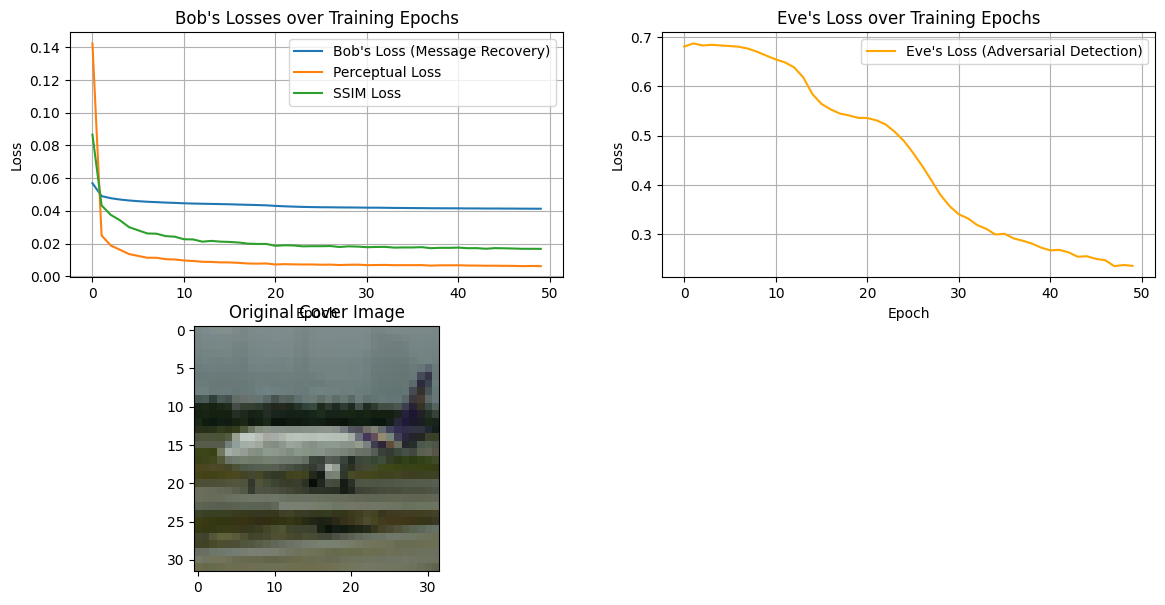

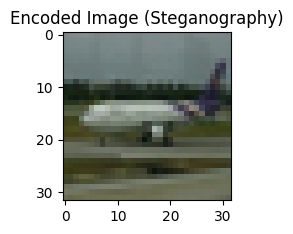

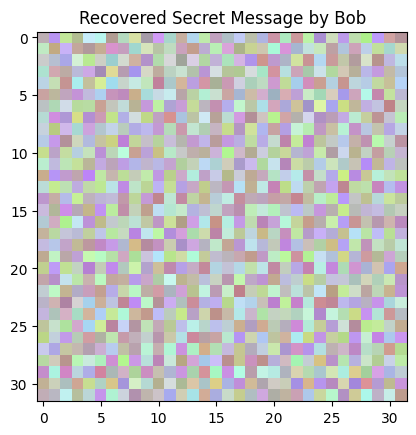

Eve's Detection Result (Average Probability of Hidden Message): 0.10712314397096634


<Figure size 640x480 with 0 Axes>

In [ ]:
# Ensure we're using a GPU if available
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to display images
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# Perceptual Loss: Use VGG19 to compare high-level features
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features[:12].eval().to(device)
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg

    def forward(self, original, encoded):
        original_features = self.vgg(original)
        encoded_features = self.vgg(encoded)
        perceptual_loss = F.mse_loss(original_features, encoded_features)
        return perceptual_loss

# SSIM Loss Function
def ssim_loss(img1, img2):
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2  # Fixed the leading zero issue

    mu1 = F.avg_pool2d(img1, 3, 1, 1)
    mu2 = F.avg_pool2d(img2, 3, 1, 1)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.avg_pool2d(img1 * img1, 3, 1, 1) - mu1_sq
    sigma2_sq = F.avg_pool2d(img2 * img2, 3, 1, 1) - mu2_sq
    sigma12 = F.avg_pool2d(img1 * img2, 3, 1, 1) - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return 1 - ssim_map.mean()

# Alice (Encoder) model to hide a message in an image
class Alice(nn.Module):
    def __init__(self):
        super(Alice, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),  # Output image with 3 channels (RGB)
            nn.Tanh()  # Normalize between -1 and 1
        )

    def forward(self, cover_image, secret_message):
        x = torch.cat((cover_image, secret_message), dim=1)  # Concatenate along the channel axis
        return self.encoder(x)

# Bob (Decoder) model to recover the message from the encoded image
class Bob(nn.Module):
    def __init__(self):
        super(Bob, self).__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),  # Output hidden message with 3 channels
            nn.Sigmoid()  # Normalize between 0 and 1
        )

    def forward(self, encoded_image):
        return self.decoder(encoded_image)

# Eve (Adversary) model to detect hidden messages
class Eve(nn.Module):
    def __init__(self):
        super(Eve, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),  # Output binary classification (0: no message, 1: message)
            nn.Sigmoid()
        )

    def forward(self, image):
        return self.discriminator(image)

# Initialize the models and move to GPU if available
alice = Alice().to(device)
bob = Bob().to(device)
eve = Eve().to(device)

# Perceptual loss module
perceptual_loss_fn = PerceptualLoss()

# Loss functions and optimizers
criterion = nn.MSELoss()  # Loss function for Alice and Bob (message accuracy)
adv_criterion = nn.BCELoss()  # Binary Cross Entropy for Eve (adversarial detection)
alice_optimizer = optim.Adam(alice.parameters(), lr=0.001)
bob_optimizer = optim.Adam(bob.parameters(), lr=0.001)
eve_optimizer = optim.Adam(eve.parameters(), lr=0.001)

# Dataset and DataLoader (using CIFAR10 dataset for simplicity)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

# Lists to store the loss values for plotting
bob_losses = []
eve_losses = []
ssim_losses = []
perceptual_losses = []

# Training Loop with increased epochs
epochs = 50  # Increased number of epochs to give Eve more training time

for epoch in range(epochs):
    bob_loss_epoch = 0
    eve_loss_epoch = 0
    ssim_loss_epoch = 0
    perceptual_loss_epoch = 0

    for i, (images, _) in enumerate(trainloader):
        cover_images = images.to(device)
        secret_messages = torch.rand(images.size(0), 3, 32, 32).to(device)

        # Train Alice and Bob
        alice_optimizer.zero_grad()
        bob_optimizer.zero_grad()

        # Alice hides the secret message
        encoded_images = alice(cover_images, secret_messages)

        # Bob recovers the secret message
        recovered_messages = bob(encoded_images)

        # Loss between original and recovered message
        loss_bob = criterion(recovered_messages, secret_messages)

        # Perceptual and SSIM losses
        perceptual_loss = perceptual_loss_fn(cover_images, encoded_images)
        ssim_loss_value = ssim_loss(cover_images, encoded_images)

        # Combined loss: message recovery + perceptual + SSIM
        total_loss = loss_bob + 0.5 * perceptual_loss + 0.5 * ssim_loss_value
        total_loss.backward()

        alice_optimizer.step()
        bob_optimizer.step()

        bob_loss_epoch += loss_bob.item()
        perceptual_loss_epoch += perceptual_loss.item()
        ssim_loss_epoch += ssim_loss_value.item()

        # Train Eve (Adversary)
        eve_optimizer.zero_grad()
        real_labels = torch.ones(images.size(0), 1, 32, 32).to(device)
        fake_labels = torch.zeros(images.size(0), 1, 32, 32).to(device)

        eve_real_loss = adv_criterion(eve(cover_images), real_labels)
        eve_fake_loss = adv_criterion(eve(encoded_images.detach()), fake_labels)

        eve_loss = (eve_real_loss + eve_fake_loss) / 2
        eve_loss.backward()
        eve_optimizer.step()

        eve_loss_epoch += eve_loss.item()

    # Average losses for the epoch
    bob_losses.append(bob_loss_epoch / len(trainloader))
    eve_losses.append(eve_loss_epoch / len(trainloader))
    perceptual_losses.append(perceptual_loss_epoch / len(trainloader))
    ssim_losses.append(ssim_loss_epoch / len(trainloader))

    print(f'Epoch [{epoch+1}/{epochs}], Total Loss: {total_loss.item():.4f}, Eve Loss: {eve_loss.item():.4f}')

# After training, plot the losses
plt.figure(figsize=(14, 7))

# Plot Bob's loss (message recovery), SSIM loss, and perceptual loss
plt.subplot(2, 2, 1)
plt.plot(bob_losses, label="Bob's Loss (Message Recovery)")
plt.plot(perceptual_losses, label="Perceptual Loss")
plt.plot(ssim_losses, label="SSIM Loss")
plt.title("Bob's Losses over Training Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Eve's loss
plt.subplot(2, 2, 2)
plt.plot(eve_losses, label="Eve's Loss (Adversarial Detection)", color="orange")
plt.title("Eve's Loss over Training Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Sample images from the last epoch
with torch.no_grad():
    sample_cover = cover_images[0].cpu()
    sample_encoded = encoded_images[0].cpu()
    sample_recovered = recovered_messages[0].cpu()

    # Show original, encoded, recovered messages, and Eve's output
    plt.subplot(2, 2, 3)
    imshow(sample_cover, title="Original Cover Image")

    plt.subplot(2, 2, 4)
    imshow(sample_encoded, title="Encoded Image (Steganography)")

    # Show recovered secret message by Bob
    plt.figure()
    imshow(sample_recovered, title="Recovered Secret Message by Bob")

    # Show Eve’s detection result (average probability of hidden message across the feature map)
    eve_detection = eve(sample_encoded.unsqueeze(0).to(device)).mean().item()
    print(f"Eve's Detection Result (Average Probability of Hidden Message): {eve_detection}")

plt.tight_layout()
plt.show()
